# Importation et étude du dataset

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")
import missingno as msno
import scipy.stats as st

# Suppress FutureWarnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

raw_data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

raw_data.shape

(3376, 46)

In [158]:
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [159]:
raw_data.duplicated().sum()

0

In [160]:
raw_data['ComplianceStatus'].value_counts()

ComplianceStatus
Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: count, dtype: int64

In [161]:
raw_data['BuildingType'].unique().tolist()

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Campus',
 'Multifamily LR (1-4)',
 'Multifamily HR (10+)',
 'Nonresidential WA']

# Nettoyage des données

In [162]:
#Récupération des colonnes intéressantes
col = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'ComplianceStatus', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
data = raw_data[col].copy()

#Nettoyage en fonction des variables ComplianceStatus et BuildingType/PrimaryPropertyType/LargestPropertyUseType pour supprimer
#les individus non pertinents pour notre étude
data = data[data['ComplianceStatus'] == 'Compliant']
data = data.drop(['ComplianceStatus'], axis=1)
data = data[~data['BuildingType'].isin(['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)'])]
data = data[~data['PrimaryPropertyType'].isin(['Low-Rise Multifamily'])]
data = data[~data['LargestPropertyUseType'].isin(['Multifamily Housing'])]

#Suppression d'un individu avec une valeur SiteEnergyUseWN manquante
data = data.dropna(subset=['SiteEnergyUseWN(kBtu)'])

#Suppression de 9 individus dont la valeur de SiteEnergyUseWN(kBtu) est nulle
data = data[data['SiteEnergyUseWN(kBtu)']!=0]

#Modification du BuildingType Nonresidential WA en NonResidential car un seul individu dans cette catégorie
data.loc[data['BuildingType']=='Nonresidential WA', 'BuildingType'] = 'NonResidential'

#Modification du type de quelques colonnes
colToCateg = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
data[colToCateg] = data[colToCateg].astype('category')
data['NumberofBuildings'] = data['NumberofBuildings'].astype('int64')

data = data.reset_index(drop=True)

In [163]:
data.describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity
count,1527.000000,1527.000000,1527.000000,1.527000e+03,1527.000000,1.527000e+03,1.523000e+03,828.000000,338.000000,986.000000,1.527000e+03,1.527000e+03,1.527000e+03,1.527000e+03,1527.000000,1527.000000,1527.000000
mean,1961.590046,1.106745,4.233792,1.148026e+05,13711.055010,1.010916e+05,9.399126e+04,36130.770890,14709.660943,63.518256,4.940897e+05,5.710087e+06,2.057460e+06,8.514898e+06,78.100982,187.216785,1.676758
std,32.793641,1.202226,6.741022,1.970484e+05,43767.870936,1.747893e+05,1.631042e+05,66418.833605,36919.642794,28.891679,5.329048e+06,1.379293e+07,9.774772e+06,2.290603e+07,76.439223,732.220239,2.421245
min,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000e+00,-1.154170e+05,0.000000e+00,5.811420e+04,1.500000,-0.800000,-0.020000
25%,1930.000000,1.000000,1.000000,2.881400e+04,0.000000,2.792050e+04,2.514200e+04,5375.000000,2574.250000,43.250000,0.000000e+00,7.283915e+05,0.000000e+00,1.334886e+06,37.250000,20.395000,0.360000
50%,1965.000000,1.000000,2.000000,4.802000e+04,0.000000,4.606800e+04,4.192200e+04,12011.500000,5744.000000,71.000000,0.000000e+00,1.705793e+06,4.960960e+05,2.830675e+06,56.299999,49.900000,0.890000
75%,1988.000000,1.000000,4.000000,1.060205e+05,0.000000,9.480650e+04,9.196750e+04,31447.500000,12356.500000,88.000000,0.000000e+00,5.258300e+06,1.534706e+06,7.564924e+06,88.300003,147.070000,1.980000
max,2015.000000,27.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,639931.000000,459748.000000,100.000000,1.349435e+08,2.745325e+08,2.979090e+08,4.716139e+08,834.400024,16870.980000,34.090000


In [164]:
data.sort_values(by='NumberofBuildings', ascending=False)

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity
89,Campus,University,DELRIDGE,1970,27,2,441071,0,441071,College/University,...,NaN,NaN,NaN,0.0,25314575.0,12987166.0,41151732.00,85.199997,866.23,1.96
1005,Campus,Other,MAGNOLIA / QUEEN ANNE,1955,23,1,260241,0,260241,Other,...,NaN,NaN,NaN,0.0,26894616.0,7118362.0,36034584.00,138.500000,565.55,2.17
1210,Campus,University,MAGNOLIA / QUEEN ANNE,1945,14,2,537000,0,537000,College/University,...,NaN,NaN,NaN,0.0,22619097.0,67990538.0,96775464.00,181.300003,3768.66,7.02
127,Campus,Large Office,GREATER DUWAMISH,1980,14,2,334368,31874,302494,Office,...,Other - Utility,16766.0,NaN,0.0,45321378.0,8145300.0,54136068.00,161.899994,748.55,2.24
106,Campus,University,NORTHWEST,1970,11,2,694072,111625,582447,College/University,...,NaN,NaN,NaN,0.0,33450832.0,2440648.0,37410800.00,56.099998,362.82,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,NonResidential,Medical Office,EAST,1963,0,3,39115,0,39115,Medical Office,...,NaN,NaN,42.0,0.0,2998320.0,736988.0,3838425.00,76.800003,60.04,1.53
359,NonResidential,Other,North,1969,0,2,98539,0,98539,Strip Mall,...,NaN,NaN,NaN,0.0,5266334.0,184107.0,5502264.50,55.799999,46.49,0.47
1097,NonResidential,Worship Facility,NORTHWEST,1951,0,2,41600,0,41600,Worship Facility,...,NaN,NaN,58.0,0.0,704075.0,491090.0,1376059.25,33.099998,30.99,0.74
1294,NonResidential,Small- and Mid-Sized Office,LAKE UNION,1997,0,3,31686,7358,24328,Office,...,Food Service,3743.0,35.0,0.0,2305643.0,0.0,2305643.50,72.800003,16.07,0.51


In [165]:
data.sort_values(by='NumberofFloors', ascending=False)

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity
856,NonResidential,Worship Facility,GREATER DUWAMISH,1977,1,99,21948,0,21948,Worship Facility,...,NaN,NaN,80.0,0.000,326001.0,0.0,3.260012e+05,14.900000,2.27,0.10
494,NonResidential,Large Office,DOWNTOWN,1985,1,76,1952220,319400,1632820,Office,...,NaN,NaN,86.0,0.000,87851862.0,5085763.0,9.253726e+07,55.099998,882.56,0.45
181,Nonresidential COS,Large Office,DOWNTOWN,1990,1,63,1354987,159600,1195387,Office,...,Other,18656.0,89.0,0.000,61576180.0,0.0,6.157618e+07,50.400002,429.27,0.32
237,NonResidential,Large Office,DOWNTOWN,1989,1,56,1605578,389860,1215718,Office,...,Other,30744.0,97.0,915654.875,46081813.0,2520230.0,5.098450e+07,37.900002,525.78,0.33
218,NonResidential,Large Office,DOWNTOWN,1988,1,55,1400000,285000,1115000,Office,...,Other,133598.0,92.0,2179487.750,49472833.0,1426840.0,5.514030e+07,48.500000,588.90,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,NonResidential,Residence Hall,NORTHEAST,2011,1,0,176225,0,176225,Residence Hall/Dormitory,...,NaN,NaN,91.0,0.000,3424588.0,1502107.0,5.209464e+06,29.600000,103.65,0.59
1493,NonResidential,Residence Hall,NORTHEAST,1953,1,0,166991,0,166991,Residence Hall/Dormitory,...,NaN,NaN,19.0,0.000,8902529.0,7063329.0,1.659197e+07,99.400002,437.20,2.62
1494,NonResidential,Residence Hall,NORTHEAST,1970,1,0,89392,0,89392,Residence Hall/Dormitory,...,NaN,NaN,16.0,0.000,6960904.0,0.0,7.483350e+06,83.699997,48.53,0.54
1495,NonResidential,Residence Hall,NORTHEAST,2011,1,0,97040,0,97040,Residence Hall/Dormitory,...,NaN,NaN,69.0,0.000,3129824.0,764318.0,4.075094e+06,42.000000,62.41,0.64


In [166]:
data['NumberofFloors'].value_counts()

NumberofFloors
1     423
2     348
3     238
4     136
5     100
6      79
7      32
8      22
10     18
11     18
0      15
14      9
12      9
9       8
13      7
42      5
19      5
15      5
17      3
29      3
22      3
21      3
23      3
16      3
18      3
24      3
25      3
33      3
34      2
36      2
20      2
41      2
56      1
28      1
76      1
27      1
46      1
30      1
47      1
55      1
63      1
37      1
49      1
99      1
Name: count, dtype: int64

Traitement des valeurs aberrantes de ['NumberofBuildings', 'NumberofFloors'], à savoir les 0 et le 99 de NumberofFloors (ça ne colle pas avec la superficie)

In [167]:
for col in ['NumberofBuildings', 'NumberofFloors']:
    for index, row in data[data[col] < 1].iterrows():
            data.at[index, col] = data[data['PrimaryPropertyType']==row['PrimaryPropertyType']][col].mean().round(0)
data.loc[data['NumberofFloors'] == 99, 'NumberofFloors'] = data[data['PrimaryPropertyType']=='Worship Facility']['NumberofFloors'].mean().round(0)

Traitement des valeurs aberrantes de TotalGHGEmissions : un individu possède une valeur négative ce qui ne devrait pas être possible.  
Etant donné que ça touche directement une variable qu'on cherche à étudier, je préfère supprimer l'individu pour ne prendre aucun risque.

In [168]:
display(data.loc[data['TotalGHGEmissions']<0])

data = data[data['TotalGHGEmissions']>=0]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity
1470,NonResidential,Small- and Mid-Sized Office,CENTRAL,2013,1,6,52000,0,52000,Office,...,NaN,NaN,100.0,0.0,-115417.0,0.0,240132.0938,5.0,-0.8,-0.02


La variable 'Neighborhood' contient des doublons à cause de la casse et certaines valeurs pourraient être regroupées :

In [169]:
data['Neighborhood'].unique().tolist()

['DOWNTOWN',
 'NORTHEAST',
 'EAST',
 'LAKE UNION',
 'GREATER DUWAMISH',
 'MAGNOLIA / QUEEN ANNE',
 'BALLARD',
 'NORTHWEST',
 'CENTRAL',
 'SOUTHWEST',
 'SOUTHEAST',
 'DELRIDGE',
 'NORTH',
 'North',
 'Delridge',
 'Ballard',
 'Northwest',
 'Central',
 'DELRIDGE NEIGHBORHOODS']

In [170]:
data['Neighborhood'] = data['Neighborhood'].str.upper()
data['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS','DELRIDGE', inplace=True)

In [171]:
data['Neighborhood'].unique().tolist()

['DOWNTOWN',
 'NORTHEAST',
 'EAST',
 'LAKE UNION',
 'GREATER DUWAMISH',
 'MAGNOLIA / QUEEN ANNE',
 'BALLARD',
 'NORTHWEST',
 'CENTRAL',
 'SOUTHWEST',
 'SOUTHEAST',
 'DELRIDGE',
 'NORTH']

Nous avons 4 valeurs nulles dans 'LargestPropertyUseType' et 'LargestPropertyUseTypeGFA'.  
Nous allons corriger ce problème de cette façon :  
- Pour 'LargestPropertyUseType', en fonction de la catégorie 'PrimaryPropertyType' de l'individu nous allons regarde la 'LargestPropertyUseType' la plus répandu et lui attribuer.  
- Pour 'LargestPropertyUseTypeGFA', nous allons mettre la valeur de 'PropertyGFABuilding(s)'.

In [172]:
data.isna().sum()

BuildingType                          0
PrimaryPropertyType                   0
Neighborhood                          0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        698
SecondLargestPropertyUseTypeGFA     698
ThirdLargestPropertyUseType        1188
ThirdLargestPropertyUseTypeGFA     1188
ENERGYSTARScore                     541
SteamUse(kBtu)                        0
Electricity(kBtu)                     0
NaturalGas(kBtu)                      0
SiteEnergyUseWN(kBtu)                 0
SiteEUIWN(kBtu/sf)                    0
TotalGHGEmissions                     0
GHGEmissionsIntensity                 0
dtype: int64

In [173]:
data[data['LargestPropertyUseTypeGFA'].isna()].loc[:,['PrimaryPropertyType','NumberofBuildings','LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType']]

,PrimaryPropertyType,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType
296,Self-Storage Facility,2,NaN,NaN,NaN
745,Hotel,1,NaN,NaN,NaN
1237,Small- and Mid-Sized Office,1,NaN,NaN,NaN
1254,Restaurant,1,NaN,NaN,NaN


In [174]:
for index, row in data[data['LargestPropertyUseType'].isna()].iterrows():
    data.loc[index, 'LargestPropertyUseTypeGFA'] = data.loc[index, 'PropertyGFABuilding(s)']
    data.loc[index, 'LargestPropertyUseType'] = data.loc[data['PrimaryPropertyType']==data.loc[index, 'PrimaryPropertyType']]['LargestPropertyUseType'].value_counts().index[0]

In [175]:
for index, row in data[data['LargestPropertyUseType'].isna()].iterrows():
    data.loc[index, 'LargestPropertyUseTypeGFA'] = data.loc[index, 'PropertyGFABuilding(s)']
    data.loc[index, 'LargestPropertyUseType'] = data.loc[data['PrimaryPropertyType']==data.loc[index, 'PrimaryPropertyType']]['LargestPropertyUseType'].mode()

In [176]:
data['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  480
Non-Refrigerated Warehouse                              197
Other                                                    95
Retail Store                                             93
Hotel                                                    76
Worship Facility                                         67
Distribution Center                                      54
K-12 School                                              50
Supermarket/Grocery Store                                41
Medical Office                                           41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    28
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
College/University                                       21
Senior Care Commu

In [177]:
data.shape

(1526, 23)

# Analyses/Graphes

In [127]:
data.describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity
count,1526.000000,1526.000000,1526.000000,1.526000e+03,1526.000000,1.526000e+03,1.526000e+03,828.000000,338.000000,985.000000,1.526000e+03,1.526000e+03,1.526000e+03,1.526000e+03,1526.000000,1526.000000,1526.000000
mean,1961.556356,1.142857,4.208388,1.148438e+05,13720.039974,1.011238e+05,9.393895e+04,36130.770890,14709.660943,63.481218,4.944135e+05,5.713904e+06,2.058808e+06,8.520320e+06,78.148886,187.339993,1.677870
std,32.777948,1.187050,6.279278,1.971065e+05,43780.809950,1.748421e+05,1.629549e+05,66418.833605,36919.642794,28.882927,5.330779e+06,1.379665e+07,9.777834e+06,2.291256e+07,76.441349,732.444437,2.421649
min,1900.000000,1.000000,1.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,1.500000,0.000000,0.000000
25%,1930.000000,1.000000,1.000000,2.881100e+04,0.000000,2.791425e+04,2.518800e+04,5375.000000,2574.250000,43.000000,0.000000e+00,7.294528e+05,0.000000e+00,1.337961e+06,37.299999,20.505000,0.360000
50%,1965.000000,1.000000,2.000000,4.801300e+04,0.000000,4.606350e+04,4.194000e+04,12011.500000,5744.000000,71.000000,0.000000e+00,1.711462e+06,4.962285e+05,2.831452e+06,56.350000,49.940000,0.890000
75%,1988.000000,1.000000,4.000000,1.060308e+05,0.000000,9.485325e+04,9.198375e+04,31447.500000,12356.500000,88.000000,0.000000e+00,5.261384e+06,1.534892e+06,7.570002e+06,88.300003,147.105000,1.980000
max,2015.000000,27.000000,76.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,639931.000000,459748.000000,100.000000,1.349435e+08,2.745325e+08,2.979090e+08,4.716139e+08,834.400024,16870.980000,34.090000


Visualisation du nombre de batiments construits par année.

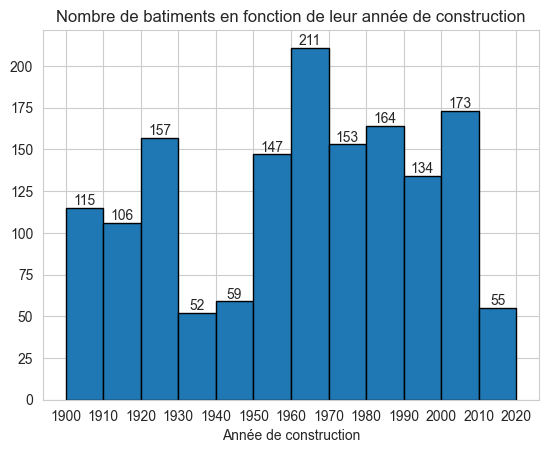

In [179]:
counts, bins, _ = plt.hist(data['YearBuilt'], range(1900,2030,10), edgecolor='black')
plt.title('Nombre de batiments en fonction de leur année de construction')
plt.xlabel('Année de construction')
plt.xticks(range(1900,2030,10))
for i, count in enumerate(counts):
        plt.text(range(1900,2030,10)[i] + 5, count, str(int(count)), ha='center', va='bottom')
plt.show()

Analyse plus en détails de nos 2 variables à étudier en fonction du BuildingType.

In [180]:
data.groupby('BuildingType', observed=True)[['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity']].describe()

SiteEUIWN(kBtu/sf)                                    \
                                count        mean        std        min   
BuildingType                                                              
Campus                           22.0  112.595455  68.759870  33.299999   
NonResidential                 1413.0   76.461642  76.207737   1.500000   
Nonresidential COS               81.0  102.607408  80.547387   8.000000   
SPS-District K-12                10.0   42.660000  11.300266  29.100000   

                                                                  \
                          25%        50%         75%         max   
BuildingType                                                       
Campus              60.100000  90.699997  134.450001  270.600006   
NonResidential      36.599998  55.299999   86.699997  834.400024   
Nonresidential COS  55.500000  78.400002  118.300003  460.100006   
SPS-District K-12   33.624999  41.650002   50.850001   61.700001   

                   GHGEmissionsIntensity                                   \
                                   count      mean       std   min    25%   
BuildingType                                                                
Campus                              22.0  4.467727  7.114071  0.52  1.630   
NonResidential                    1413.0  1.572661  2.178731  0.00  0.340   
Nonresidential COS                  81.0  2.832840  3.308923  0.06  1.010   
SPS-District K-12                   10.0  1.051000  0.579472  0.39  0.635   

                                         
                      50%    75%    max  
BuildingType                             
Campus              1.975  4.080  34.09  
NonResidential      0.820  1.890  25.71  
Nonresidential COS  1.900  3.090  16.99  
SPS-District K-12   0.855  1.285   2.19

Etude de la taille des batiments en fonction de différentes catégories.

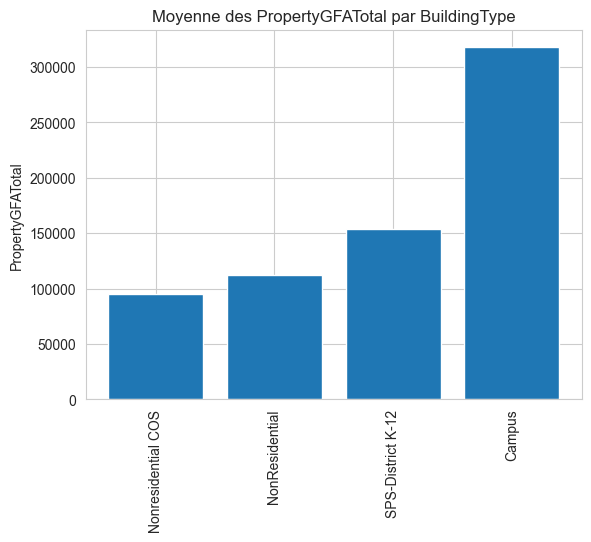

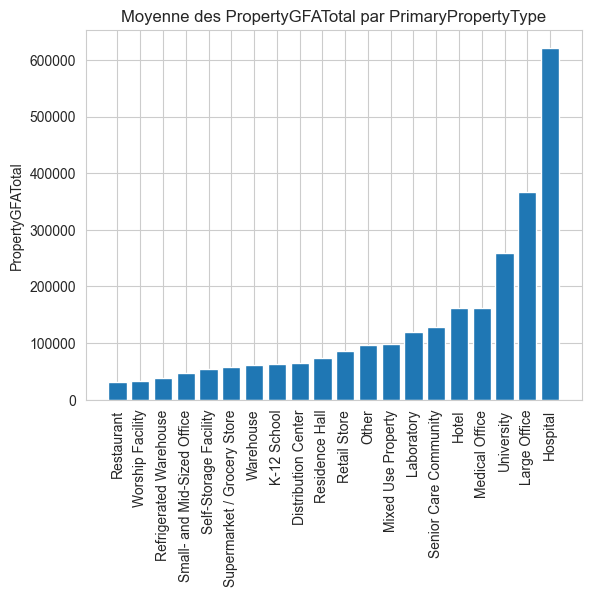

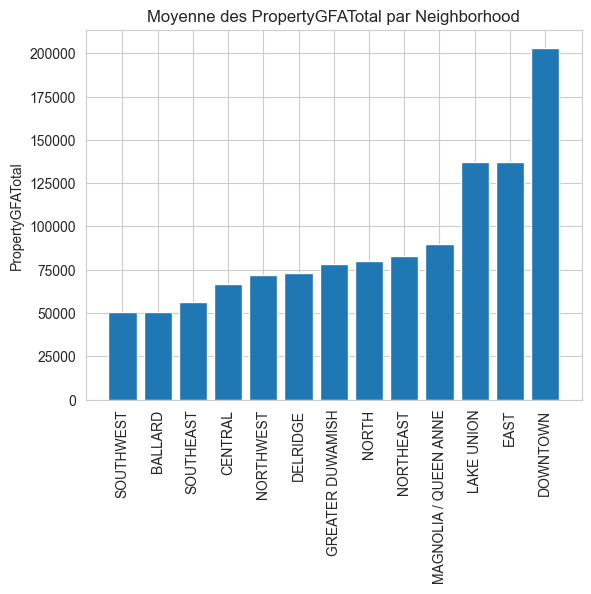

In [181]:
for k in ['BuildingType','PrimaryPropertyType', 'Neighborhood']:
    mean_categ = data.groupby(k, observed=True)['PropertyGFATotal'].mean().reset_index().sort_values(by='PropertyGFATotal', ascending=True)

    plt.bar(mean_categ[k], mean_categ['PropertyGFATotal'])
    plt.ylabel('PropertyGFATotal')
    plt.xticks(rotation=90)
    plt.title('Moyenne des PropertyGFATotal par ' + k)

    plt.show()

Etude de la consommation d'énergie en fonction de différentes catégories.

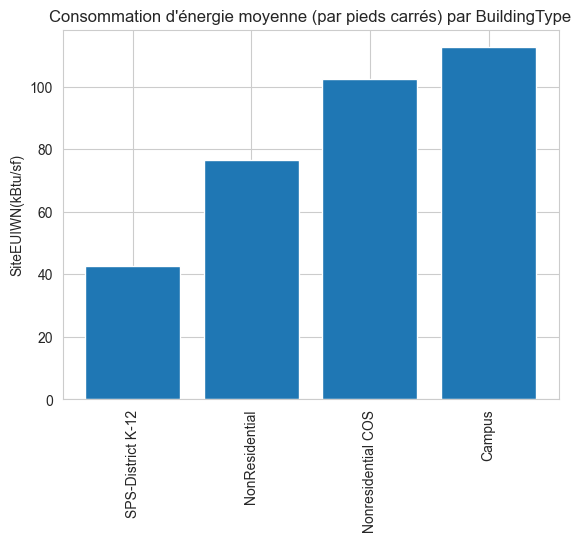

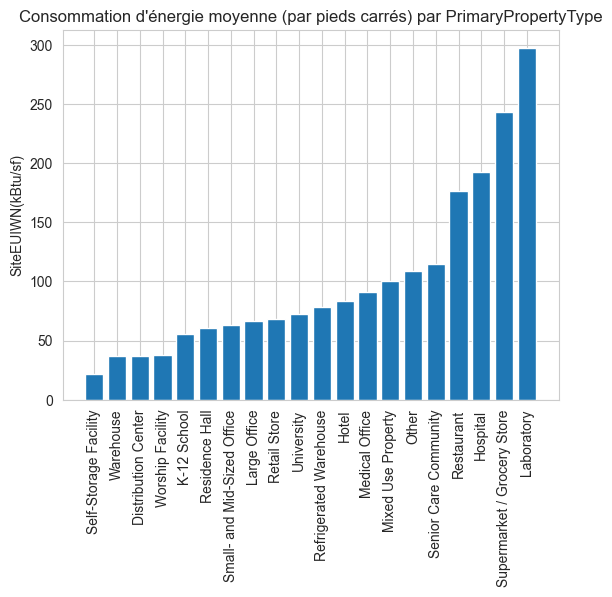

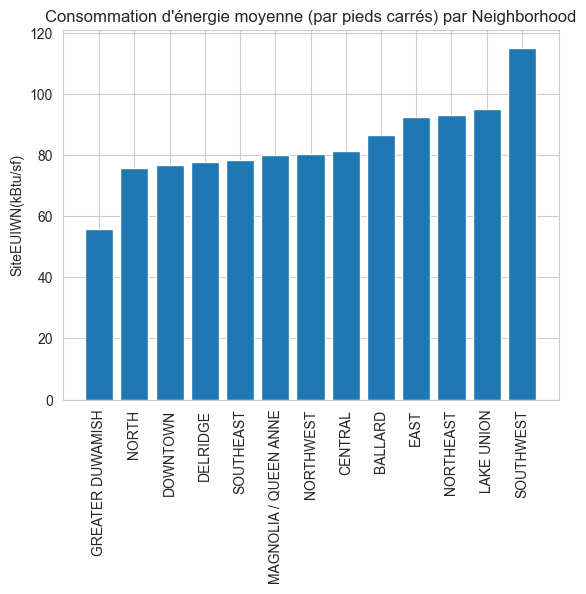

In [182]:
for k in ['BuildingType','PrimaryPropertyType', 'Neighborhood']:
    mean_categ = data.groupby(k, observed=True)['SiteEUIWN(kBtu/sf)'].mean().reset_index().sort_values(by='SiteEUIWN(kBtu/sf)', ascending=True)

    plt.bar(mean_categ[k], mean_categ['SiteEUIWN(kBtu/sf)'])
    plt.ylabel('SiteEUIWN(kBtu/sf)')
    plt.xticks(rotation=90)
    plt.title('Consommation d\'énergie moyenne (par pieds carrés) par ' + k)

    plt.show()

Etude des émissions de gaz à effet de serre en fonction de différentes catégories.

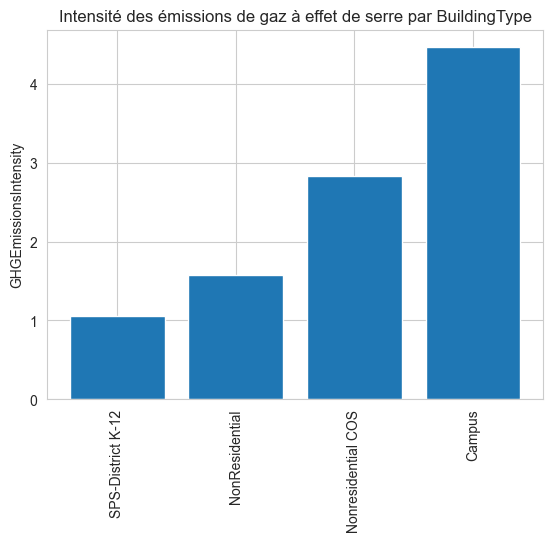

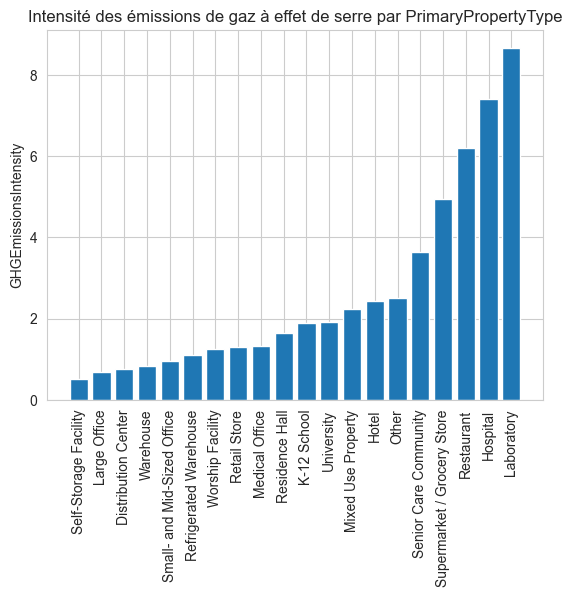

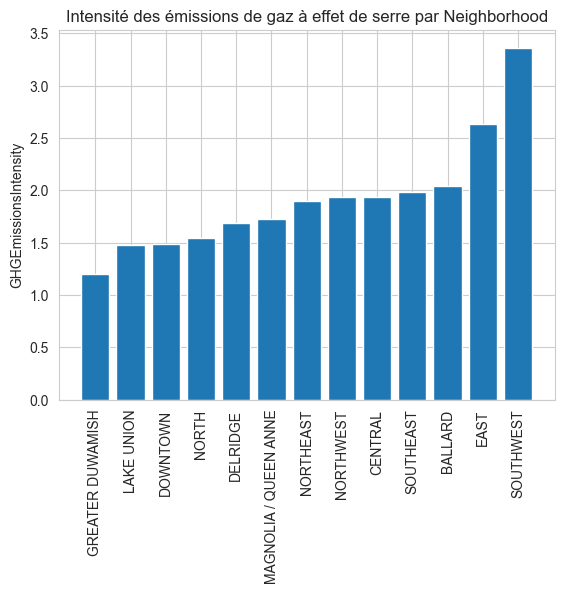

In [184]:
for k in ['BuildingType','PrimaryPropertyType', 'Neighborhood']:
    mean_categ = data.groupby(k, observed=True)['GHGEmissionsIntensity'].mean().reset_index().sort_values(by='GHGEmissionsIntensity', ascending=True)

    plt.bar(mean_categ[k], mean_categ['GHGEmissionsIntensity'])
    plt.ylabel('GHGEmissionsIntensity')
    plt.xticks(rotation=90)
    plt.title('Intensité des émissions de gaz à effet de serre par ' + k)

    plt.show()

D'après ce qu'on voit ici chacune de ces variables catégorielles semble impacter nos variables cibles.  
Je trouve ça un peu étonnant, je ne pense pas par exemple que l'emplacement d'un batiment impliquerait une différence dans l'émission de CO2.  

Je me demande s'il n'y a pas une colinéarité entre ces variables catégorielles qui entrainerait cette mauvaise conclusion.  
Il est possible par exemple que la zone SOUTHWEST soit composée principalement de type de batiment à fort émission de CO2, ce qui nous ferait croire que c'est le fait qu'un batiment est dans cette zone qui implique qu'il a un fort taux d'émission de CO2 alors qu'en réalité c'est lié à son type.  

Je vais analyser cette possibilité ici.

In [133]:
data.pivot_table(index='BuildingType', columns='PrimaryPropertyType', aggfunc='size', fill_value=0)

PrimaryPropertyType,Distribution Center,Hospital,Hotel,K-12 School,Laboratory,Large Office,Medical Office,Mixed Use Property,Other,Refrigerated Warehouse,Residence Hall,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Small- and Mid-Sized Office,Supermarket / Grocery Store,University,Warehouse,Worship Facility
BuildingType,,,,,,,,,,,,,,,,,,,,
Campus,0,0,0,4,0,1,0,4,7,0,0,1,0,0,0,0,0,5,0,0
NonResidential,51,10,75,38,10,160,38,92,181,12,21,11,85,28,20,280,40,16,178,67
Nonresidential COS,2,0,0,0,0,4,1,8,55,0,0,0,0,0,0,4,0,0,7,0
SPS-District K-12,0,0,0,8,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0


Pour BuildingType il est quelque peu compliqué d'analyser cette donnée compte tenu de l'énorme différence d'individus dans les catégories.  
Il y a 1502 batiments dans les types NonResidential, 23 Campus et 10 SPS-District K-12. Laissons de côté cette variable pour le moment.

In [134]:
data.pivot_table(index='Neighborhood', columns='PrimaryPropertyType', aggfunc='size', fill_value=0)

PrimaryPropertyType,Distribution Center,Hospital,Hotel,K-12 School,Laboratory,Large Office,Medical Office,Mixed Use Property,Other,Refrigerated Warehouse,Residence Hall,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Small- and Mid-Sized Office,Supermarket / Grocery Store,University,Warehouse,Worship Facility
Neighborhood,,,,,,,,,,,,,,,,,,,,
BALLARD,1,1,1,2,0,0,0,6,12,0,0,1,5,2,1,12,4,0,9,6
CENTRAL,0,1,0,6,0,0,3,1,11,0,0,0,2,1,2,9,1,3,2,2
DELRIDGE,5,0,0,3,0,1,1,0,11,0,0,0,6,1,0,5,0,1,5,2
DOWNTOWN,0,0,41,2,2,97,2,28,40,0,2,7,19,3,2,86,0,4,6,2
EAST,0,3,5,9,1,0,14,13,21,0,2,0,4,1,3,19,3,6,4,6
GREATER DUWAMISH,42,0,2,1,0,11,0,18,49,12,0,0,13,5,0,40,4,1,128,2
LAKE UNION,2,1,10,1,5,32,1,16,7,0,1,3,6,0,1,45,1,1,7,1
MAGNOLIA / QUEEN ANNE,3,0,6,5,2,18,1,5,30,0,2,0,3,5,1,36,5,3,10,7
NORTH,0,0,0,3,0,1,4,4,19,0,0,0,5,2,3,9,4,0,2,3


Je ne vais pas passer en détail le tableau mais on voit bel et bien que selon les quartiers, nous n'avons pas la même distribution des types de batiment.

Il est difficile de se rendre compte si ces deux variables ont un réel intérêt pour nos prédictions ou si c'est la propriété d'un building qui expliquerait la "fausse" corrélation de ces variables avec nos variables cibles.  
Je ferai dans mes modélisations un groupe de features comportant ces variables et un autre sans elles pour pouvoir comparer le résultat.  

# Features Engineering

Le but est de prédire les variables SiteEnergyUseWN(kBtu) et TotalGHGEmissions.  
Mais il faut faire attention car certaines variables sont fortement corrélées, créant ainsi une importante multicolinéarité :

In [135]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

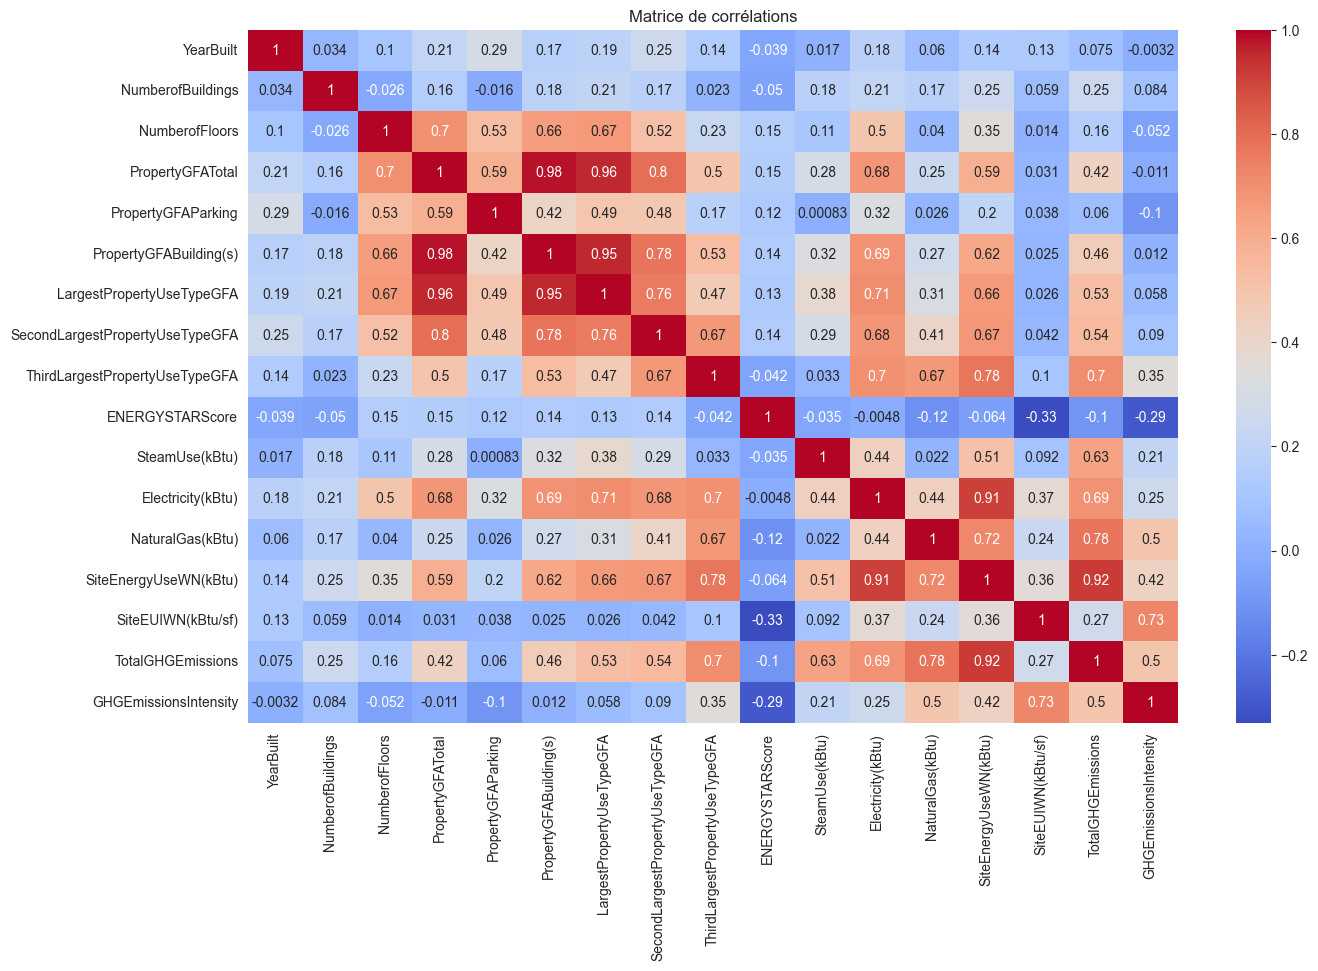

In [136]:
QuantCol= ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

correl = data[QuantCol].corr()

plt.subplots(figsize=(15, 9))
sns.heatmap(correl, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélations')
plt.show()

Nous allons donc transformer ces variables en d'autres aussi pertinentes pour notre étude mais moins corrélées.  
Nous commençons par créer nos nouvelles variables :

In [137]:
#Ajout d'une variable BuildingAge indiquant l'âge du batiment (simplement par souci de clarté) :
data.insert(data.columns.get_loc('YearBuilt') + 1, 'BuildingAge',  2016 - data['YearBuilt'])

#Ajout des variables GFAperBuilding et GFAperFloor indiquant la superficie par batiments et par étages.
data.insert(data.columns.get_loc('PropertyGFABuilding(s)') + 1, 'GFAperBuilding',  (data['PropertyGFABuilding(s)']/data['NumberofBuildings']).round(0))
data.insert(data.columns.get_loc('GFAperBuilding') + 1, 'GFAperFloor',  (data['GFAperBuilding']/data['NumberofFloors']).round(0))

#Transformation de PropertyGFABuildings et PropertyGFAParking en pourcentage de la surface totale.
data.insert(data.columns.get_loc('PropertyGFABuilding(s)') + 1, 'PercentagePropertyGFABuildings',  (data['PropertyGFABuilding(s)']/data['PropertyGFATotal']*100).round(0))
data.insert(data.columns.get_loc('PropertyGFAParking') + 1, 'PercentagePropertyGFAParking',  (data['PropertyGFAParking']/data['PropertyGFATotal']*100).round(0))

#Ajout des variables PercentageSteamUse, PercentageElectricity et PercentageNaturalGas pour avoir le pourcentage de 
#l'utilisation de chacune des sources énergetiques par batiment.
data.insert(data.columns.get_loc('SteamUse(kBtu)') + 1, 'PercentageSteamUse(kBtu)',  (data['SteamUse(kBtu)']/data['SiteEnergyUseWN(kBtu)']*100).round(0))
data.insert(data.columns.get_loc('Electricity(kBtu)') + 1, 'PercentageElectricity(kBtu)',  (data['Electricity(kBtu)']/data['SiteEnergyUseWN(kBtu)']*100).round(0))
data.insert(data.columns.get_loc('NaturalGas(kBtu)') + 1, 'PercentageNaturalGas(kBtu)',  (data['NaturalGas(kBtu)']/data['SiteEnergyUseWN(kBtu)']*100).round(0))

#Je remplace les colonnes 'LargestPropertyUseTypeGFA' 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA' 
#par leur pourcentage de la surface totale.  
data.insert(
    data.columns.get_loc('LargestPropertyUseTypeGFA') + 1,
    'LargestPropertyUseTypeGFAPourcentage',
    (data['LargestPropertyUseTypeGFA'] / data['PropertyGFATotal']*100).round(0))
data.insert(
    data.columns.get_loc('SecondLargestPropertyUseTypeGFA') + 1,
    'SecondLargestPropertyUseTypeGFAPourcentage',
    (data['SecondLargestPropertyUseTypeGFA'] /
     data['PropertyGFATotal']*100).round(0))
data.insert(
    data.columns.get_loc('ThirdLargestPropertyUseTypeGFA') + 1,
    'ThirdLargestPropertyUseTypeGFAPourcentage',
    (data['ThirdLargestPropertyUseTypeGFA'] /
     data['PropertyGFATotal']*100).round(0))

In [138]:
data.loc[:, ['SteamUse(kBtu)', 'PercentageSteamUse(kBtu)', 'Electricity(kBtu)', 'PercentageElectricity(kBtu)', 'NaturalGas(kBtu)', 'PercentageNaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)']]

,SteamUse(kBtu),PercentageSteamUse(kBtu),Electricity(kBtu),PercentageElectricity(kBtu),NaturalGas(kBtu),PercentageNaturalGas(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf)
0,2003882.00,27.0,3.946027e+06,53.0,1.276453e+06,17.0,7.456910e+06,84.300003
1,0.00,0.0,3.242851e+06,37.0,5.145082e+06,59.0,8.664479e+06,97.900002
2,21566554.00,29.0,4.952666e+07,67.0,1.493800e+06,2.0,7.393711e+07,97.699997
3,2214446.25,32.0,2.768924e+06,40.0,1.811213e+06,26.0,6.946800e+06,113.300003
4,0.00,0.0,5.368607e+06,37.0,8.803998e+06,60.0,1.465650e+07,118.699997
...,...,...,...,...,...,...,...,...
1522,0.00,0.0,6.323620e+05,62.0,2.997200e+05,29.0,1.025432e+06,56.200001
1523,0.00,0.0,3.965461e+05,38.0,5.537300e+05,53.0,1.053706e+06,65.900002
1524,0.00,0.0,1.792159e+06,30.0,3.973739e+06,66.0,6.053764e+06,460.100006
1525,0.00,0.0,3.488702e+05,45.0,3.706010e+05,47.0,7.828413e+05,55.500000


In [139]:
data.loc[:, ['PropertyGFABuilding(s)', 'PercentagePropertyGFABuildings', 'PropertyGFAParking', 'PercentagePropertyGFAParking', 'NumberofFloors', 'NumberofBuildings', 'GFAperFloor', 'GFAperBuilding', 'PropertyGFATotal']]

,PropertyGFABuilding(s),PercentagePropertyGFABuildings,PropertyGFAParking,PercentagePropertyGFAParking,NumberofFloors,NumberofBuildings,GFAperFloor,GFAperBuilding,PropertyGFATotal
0,88434,100.0,0,0.0,12,1,7370.0,88434.0,88434
1,88502,85.0,15064,15.0,11,1,8046.0,88502.0,103566
2,759392,79.0,196718,21.0,41,1,18522.0,759392.0,956110
3,61320,100.0,0,0.0,10,1,6132.0,61320.0,61320
4,113580,65.0,62000,35.0,18,1,6310.0,113580.0,175580
...,...,...,...,...,...,...,...,...,...
1522,18261,100.0,0,0.0,1,1,18261.0,18261.0,18261
1523,16000,100.0,0,0.0,1,1,16000.0,16000.0,16000
1524,13157,100.0,0,0.0,1,1,13157.0,13157.0,13157
1525,14101,100.0,0,0.0,1,1,14101.0,14101.0,14101


Nous pouvons supprimer les variables désormais inutiles :
- Yearbuilt car nous avons BuildingAge.
- SteamUse(kBtu), Electricity(kBtu) et NaturalGas(kBtu) car nous avons leur valeur en pourcentage.
- LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA etThirdLargestPropertyUseTypeGFA car nous avons leur valeur en pourcentage.

In [140]:
data = data.drop(['YearBuilt', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], axis=1)

In [141]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'BuildingAge',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PercentagePropertyGFAParking',
       'PropertyGFABuilding(s)', 'PercentagePropertyGFABuildings',
       'GFAperBuilding', 'GFAperFloor', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFAPourcentage', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFAPourcentage',
       'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFAPourcentage', 'ENERGYSTARScore',
       'PercentageSteamUse(kBtu)', 'PercentageElectricity(kBtu)',
       'PercentageNaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

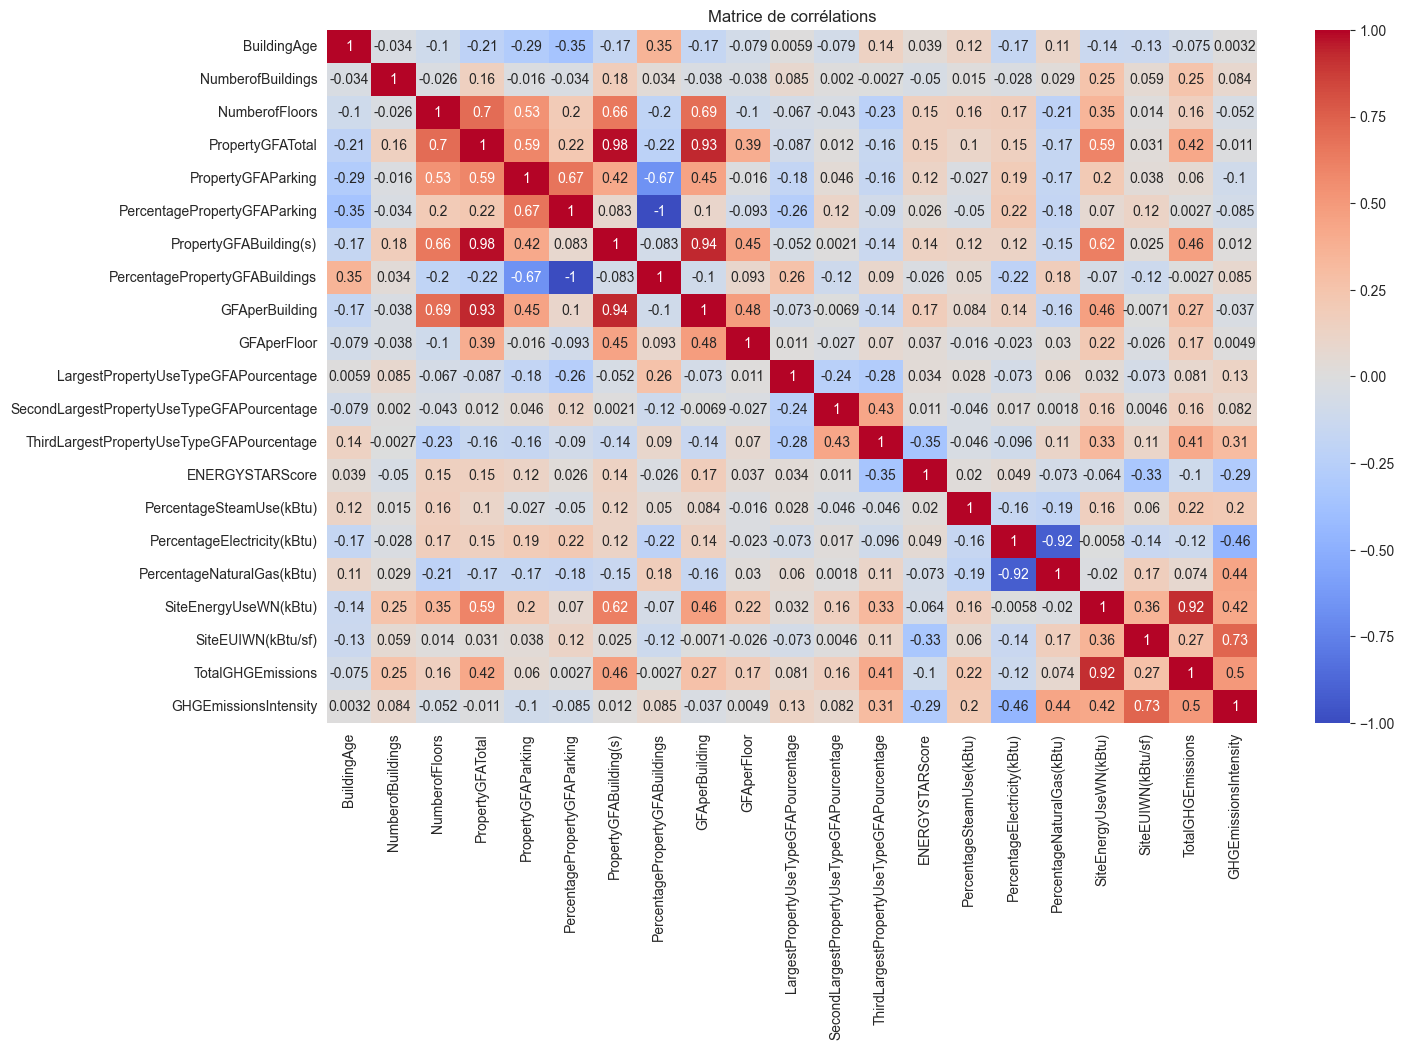

In [142]:
colCorrel = ['BuildingAge', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PercentagePropertyGFAParking', 'PropertyGFABuilding(s)', 'PercentagePropertyGFABuildings', 'GFAperBuilding', 'GFAperFloor', 'LargestPropertyUseTypeGFAPourcentage', 'SecondLargestPropertyUseTypeGFAPourcentage', 'ThirdLargestPropertyUseTypeGFAPourcentage', 'ENERGYSTARScore', 'PercentageSteamUse(kBtu)', 'PercentageElectricity(kBtu)', 'PercentageNaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

correl = data[colCorrel].corr()

plt.subplots(figsize=(15, 9))
sns.heatmap(correl, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélations')
plt.show()

On voit que les couples 'PercentageElectricity(kBtu)'/'PercentageNaturalGas(kBtu)' et 'PercentagePropertyGFABuildings'/'PercentagePropertyGFAParking' sont fortement corrélées, nous allons donc en supprimer l'une des deux. Je choisis arbitrairement de supprimer 'PercentageNaturalGas(kBtu)' et 'PercentagePropertyGFAParking'.

In [143]:
data = data.drop(['PercentageNaturalGas(kBtu)', 'PercentagePropertyGFAParking'], axis=1)

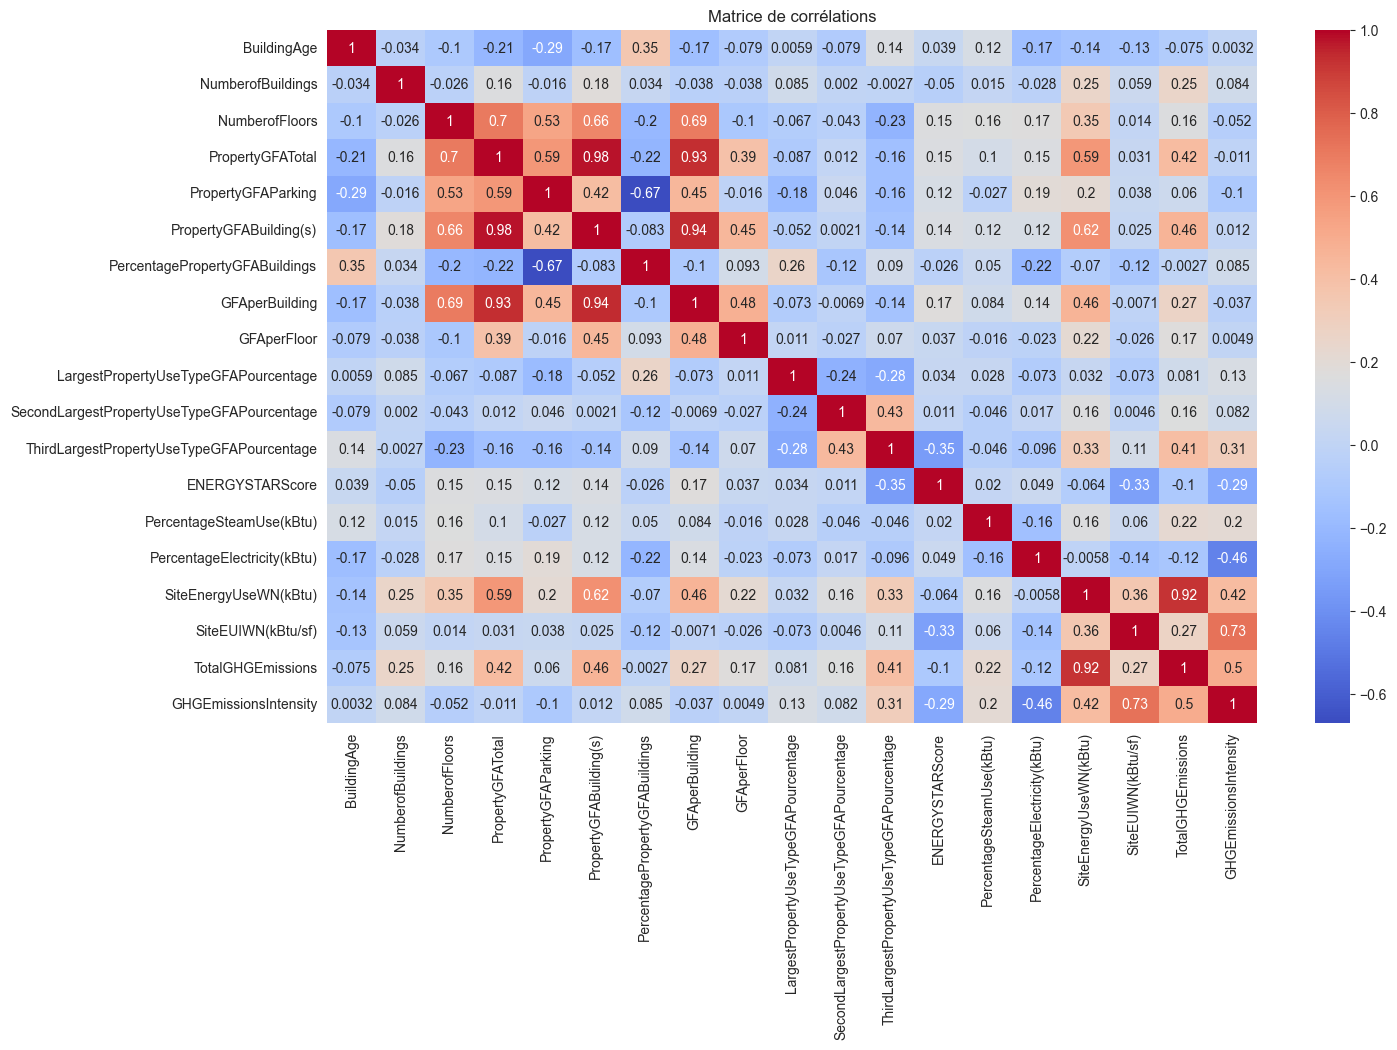

In [144]:
colCorrel = ['BuildingAge', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'PercentagePropertyGFABuildings', 'GFAperBuilding', 'GFAperFloor', 'LargestPropertyUseTypeGFAPourcentage', 'SecondLargestPropertyUseTypeGFAPourcentage', 'ThirdLargestPropertyUseTypeGFAPourcentage', 'ENERGYSTARScore', 'PercentageSteamUse(kBtu)', 'PercentageElectricity(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

correl = data[colCorrel].corr()

plt.subplots(figsize=(15, 9))
sns.heatmap(correl, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélations')
plt.show()

Il reste certaines features fortement corrélées mais je les laisse car je vais faire plusieurs tests de choix de features en entrée pour nos modélisations.  
Je ne me servirai jamais de deux features corrélées en même temps.

# ANOVA

In [145]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne']-moyenne_y)**2 for c in classes])
    return SCE/SCT

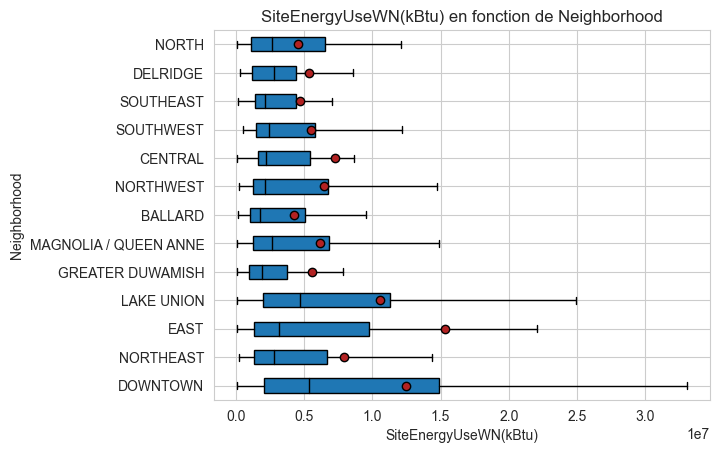

SiteEnergyUseWN(kBtu) :
F-statistic: 2.9639049617933693
p-value: 0.00042393743436155827
Rapport de corrélation : 0.022967596989677666 



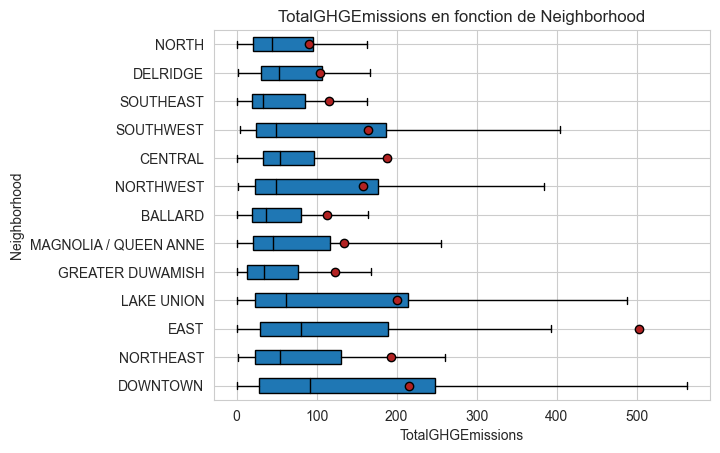

TotalGHGEmissions :
F-statistic: 2.323673451937224
p-value: 0.0060752060380782295
Rapport de corrélation : 0.018096157757364395 



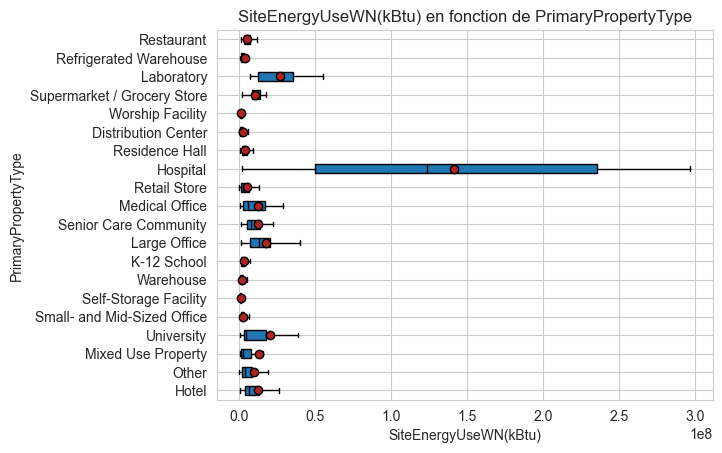

SiteEnergyUseWN(kBtu) :
F-statistic: 31.772102811279012
p-value: 3.641912590026755e-96
Rapport de corrélation : 0.28614426272570215 



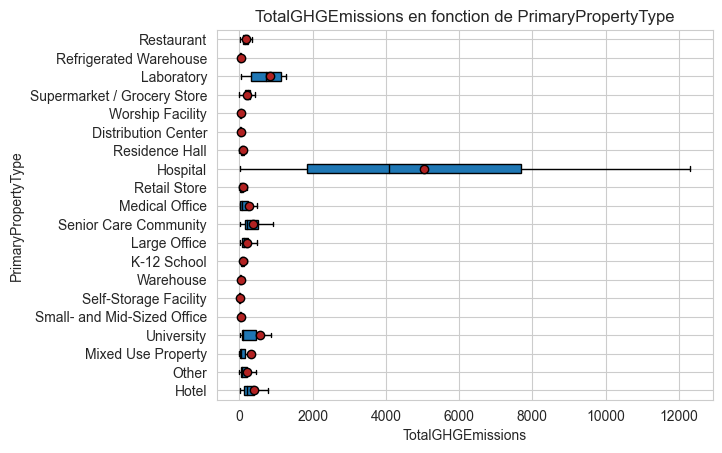

TotalGHGEmissions :
F-statistic: 37.89770439392509
p-value: 2.8229551232401513e-113
Rapport de corrélation : 0.3234672710119893 



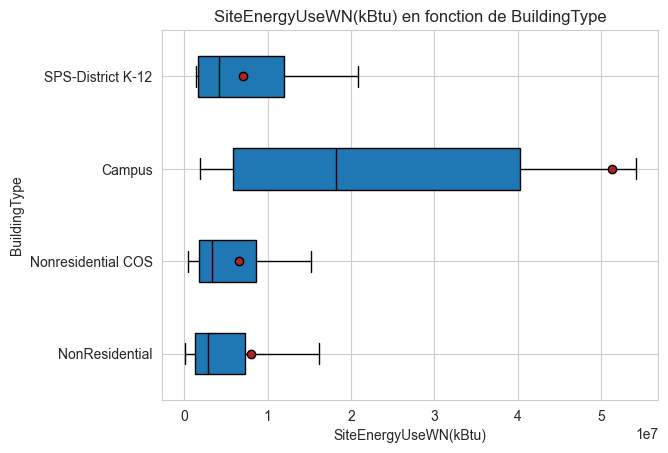

SiteEnergyUseWN(kBtu) :
F-statistic: 27.44781412301558
p-value: 2.7540635466177977e-17
Rapport de corrélation : 0.05132532112167615 



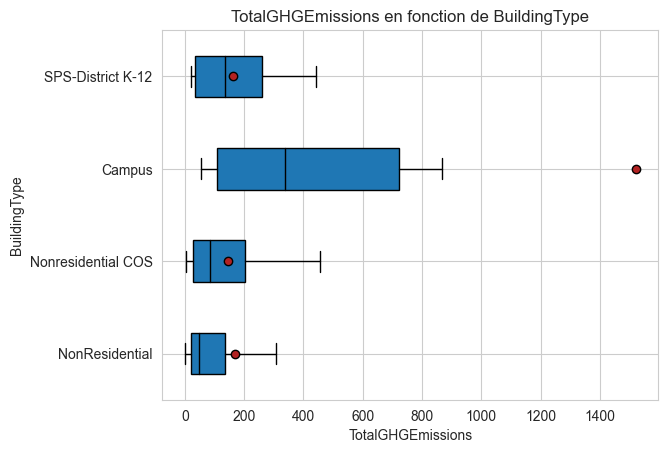

TotalGHGEmissions :
F-statistic: 25.891988988247764
p-value: 2.4612274109084637e-16
Rapport de corrélation : 0.04855731321145426 



In [146]:
for h in ['Neighborhood', 'PrimaryPropertyType', 'BuildingType']:
    for g in ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']:
        listeCateg = [data[data[h] == x][g] for x in data[h].unique()]
        f_statistic, p_value = st.f_oneway(*listeCateg)

        #print(ta)
        groupes = []
        for n in data[h].unique():
            groupes.append(data[data[h]==n][g])

        medianprops = {'color':"black"}
        meanprops = {'marker':'o', 'markeredgecolor':'black',
                    'markerfacecolor':'firebrick'}

        plt.boxplot(groupes, labels=data[h].unique(), showfliers=False, medianprops=medianprops, 
                    vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
        plt.title(g + ' en fonction de ' + h)
        plt.ylabel(h)
        plt.xlabel(g)
        plt.show()
        print(g, ':')
        print("F-statistic:", f_statistic)
        print("p-value:", p_value)
        print('Rapport de corrélation :', eta_squared(data[h],data[g]), '\n')

# Exportation du nouveau dataset

<Axes: >

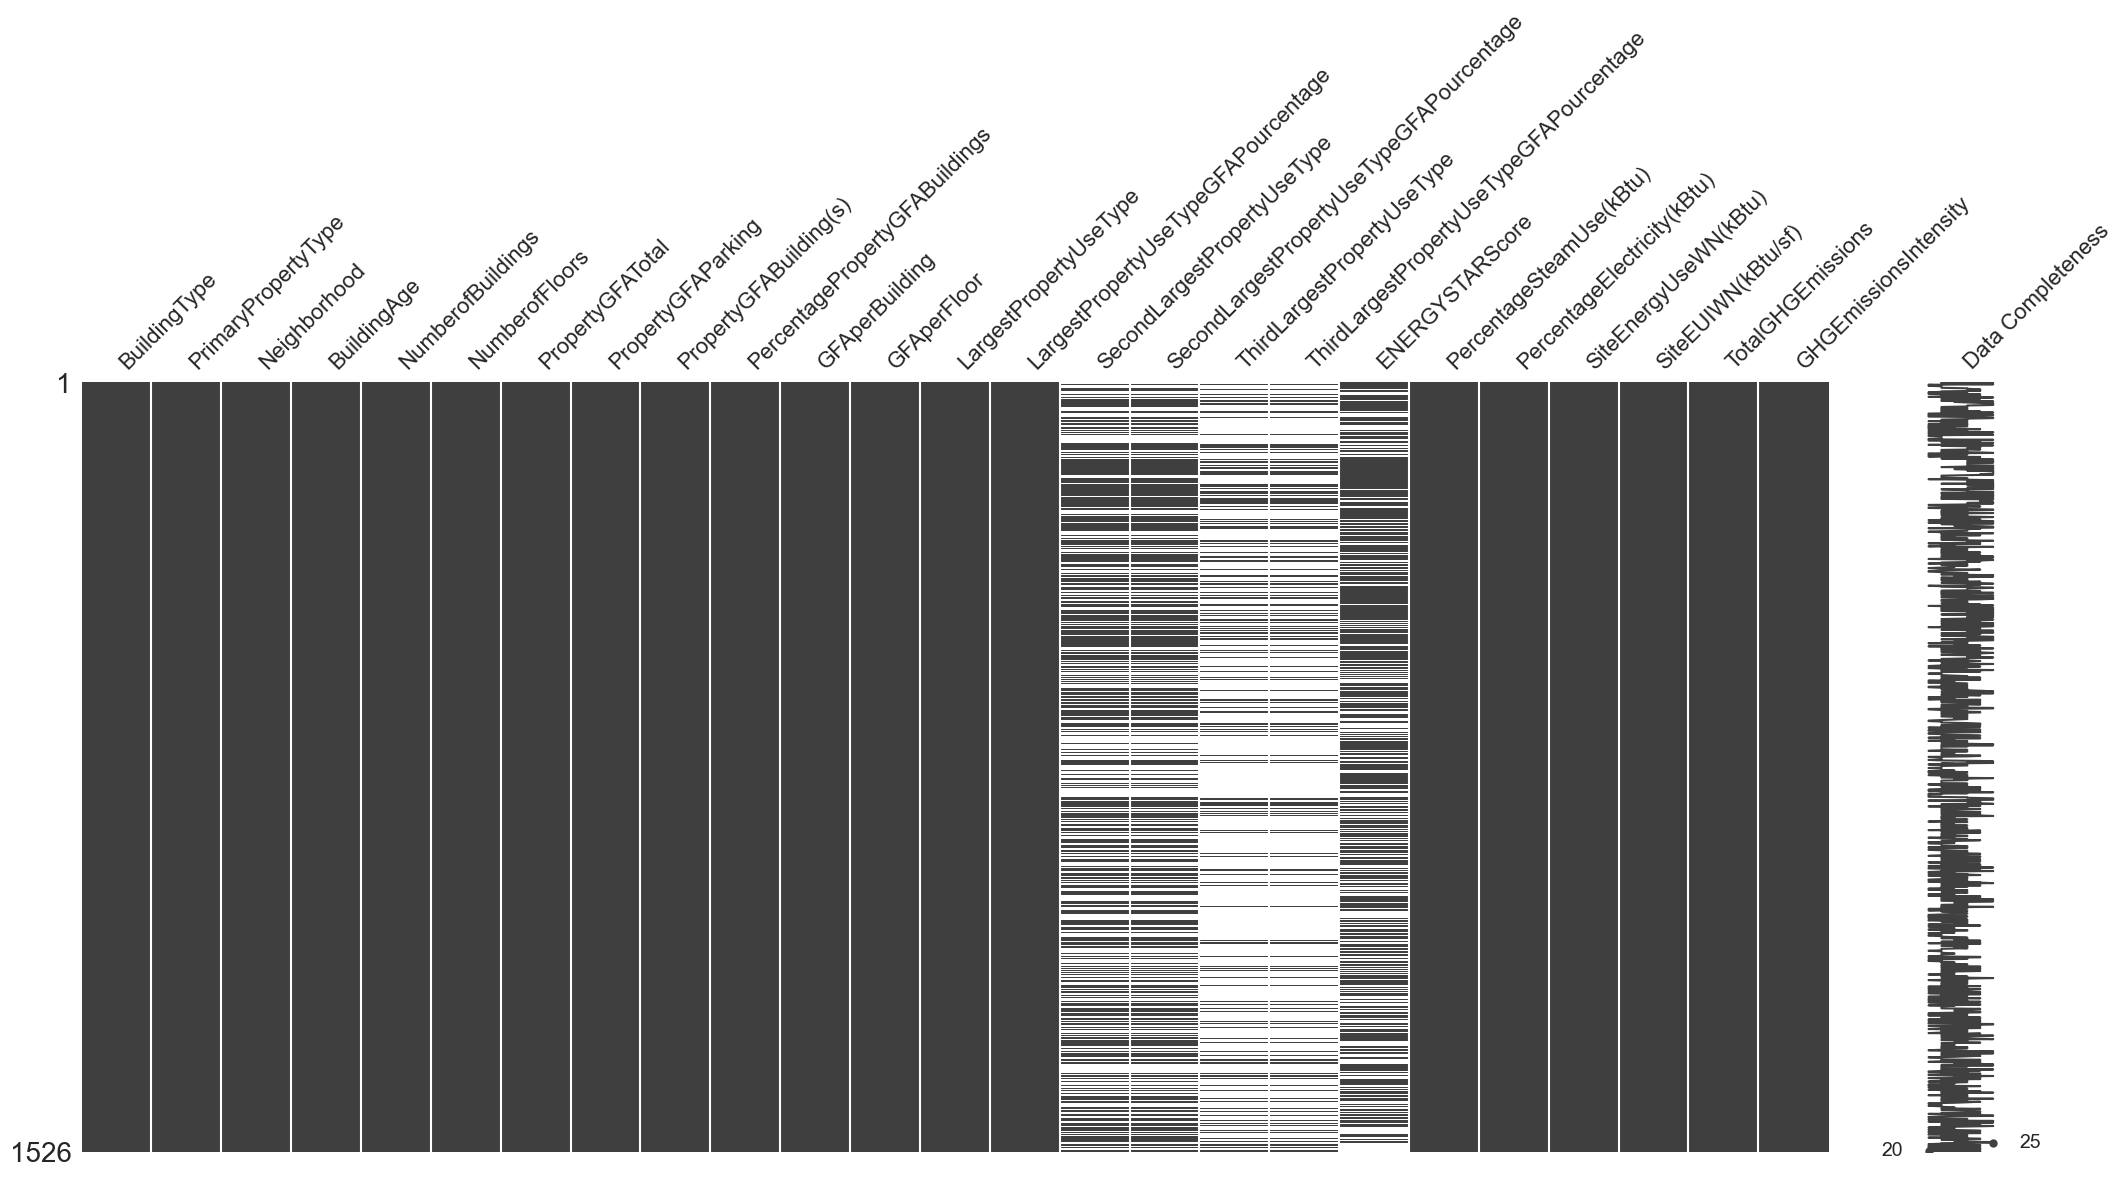

In [147]:
msno.matrix(data, labels=True)

In [148]:
data

,BuildingType,PrimaryPropertyType,Neighborhood,BuildingAge,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),PercentagePropertyGFABuildings,...,SecondLargestPropertyUseTypeGFAPourcentage,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFAPourcentage,ENERGYSTARScore,PercentageSteamUse(kBtu),PercentageElectricity(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity
0,NonResidential,Hotel,DOWNTOWN,89,1,12,88434,0,88434,100.0,...,NaN,NaN,NaN,60.0,27.0,53.0,7.456910e+06,84.300003,249.98,2.83
1,NonResidential,Hotel,DOWNTOWN,20,1,11,103566,15064,88502,85.0,...,15.0,Restaurant,4.0,61.0,0.0,37.0,8.664479e+06,97.900002,295.86,2.86
2,NonResidential,Hotel,DOWNTOWN,47,1,41,956110,196718,759392,79.0,...,NaN,NaN,NaN,43.0,29.0,67.0,7.393711e+07,97.699997,2089.28,2.19
3,NonResidential,Hotel,DOWNTOWN,90,1,10,61320,0,61320,100.0,...,NaN,NaN,NaN,56.0,32.0,40.0,6.946800e+06,113.300003,286.43,4.67
4,NonResidential,Hotel,DOWNTOWN,36,1,18,175580,62000,113580,65.0,...,39.0,Swimming Pool,0.0,75.0,0.0,37.0,1.465650e+07,118.699997,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,Nonresidential COS,Other,DELRIDGE,34,1,1,18261,0,18261,100.0,...,NaN,NaN,NaN,NaN,0.0,62.0,1.025432e+06,56.200001,20.33,1.11
1523,Nonresidential COS,Other,DOWNTOWN,12,1,1,16000,0,16000,100.0,...,NaN,NaN,NaN,NaN,0.0,38.0,1.053706e+06,65.900002,32.17,2.01
1524,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157,100.0,...,42.0,Swimming Pool,0.0,NaN,0.0,30.0,6.053764e+06,460.100006,223.54,16.99
1525,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,27,1,1,14101,0,14101,100.0,...,46.0,Pre-school/Daycare,3.0,NaN,0.0,45.0,7.828413e+05,55.500000,22.11,1.57


In [149]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'BuildingAge',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'PercentagePropertyGFABuildings', 'GFAperBuilding', 'GFAperFloor',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFAPourcentage',
       'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFAPourcentage',
       'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFAPourcentage', 'ENERGYSTARScore',
       'PercentageSteamUse(kBtu)', 'PercentageElectricity(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

In [150]:
data.to_csv('P4-cleaned.csv', index=False)

# Test des distributions pour futures transformations

<Axes: xlabel='BuildingAge', ylabel='Count'>

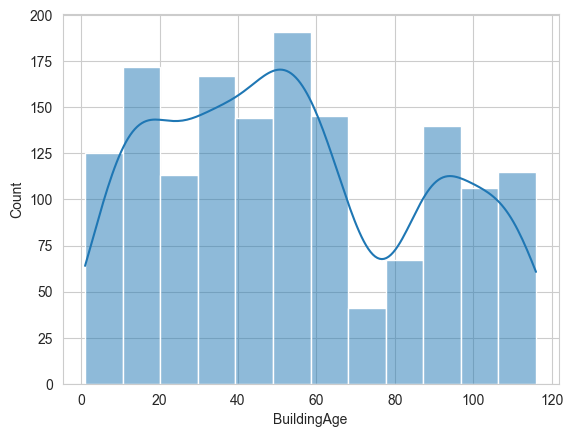

In [151]:
sns.histplot(data['BuildingAge'], kde=True)

<Axes: xlabel='PercentageElectricity(kBtu)', ylabel='Count'>

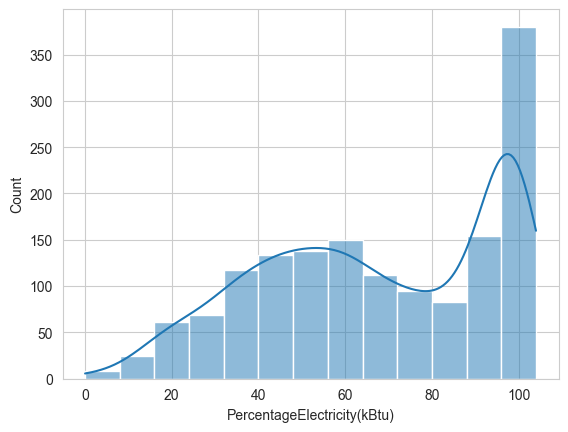

In [152]:
sns.histplot(data['PercentageElectricity(kBtu)'], kde=True)

(array([[ 19.,  75.,  98., 168., 175., 182., 133., 108., 154., 414.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([  0.        ,  13.99151824,  27.98303647,  41.97455471,
         55.96607294,  69.95759118,  83.94910942,  97.94062765,
        111.93214589, 125.92366412, 139.91518236]),
 <a list of 2 BarContainer objects>)

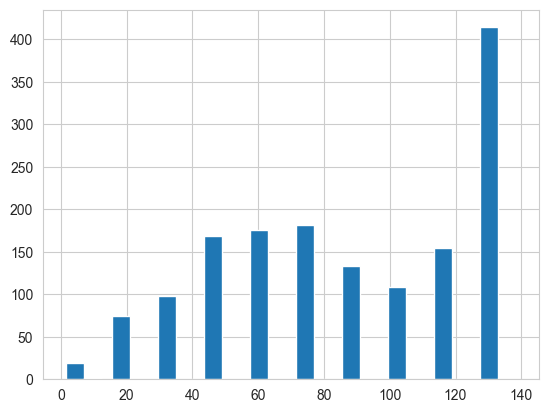

In [153]:
plt.hist(st.boxcox(data['PercentageElectricity(kBtu)'] +1))

<Axes: xlabel='PropertyGFATotal', ylabel='Count'>

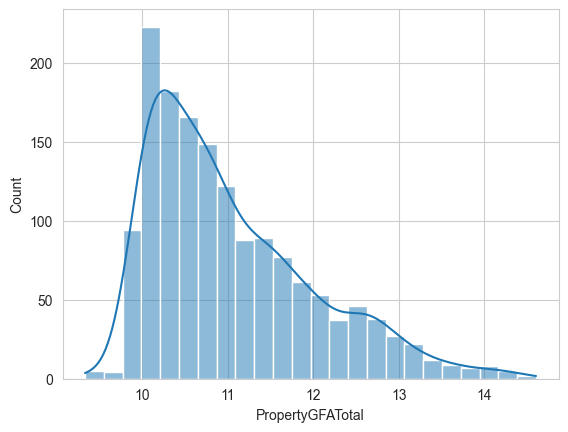

In [154]:
sns.histplot(np.log(data['PropertyGFATotal'] + 1), kde=True)

<Axes: xlabel='PropertyGFATotal_powered', ylabel='Count'>

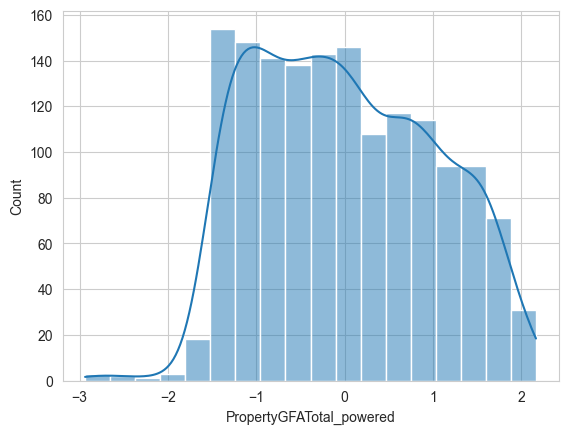

In [155]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
pt.fit(data[['PropertyGFATotal']])
data['PropertyGFATotal_powered'] = pt.transform(data[['PropertyGFATotal']])

sns.histplot(data['PropertyGFATotal_powered'], kde=True)

<Axes: xlabel='PropertyGFATotal_transformed', ylabel='Count'>

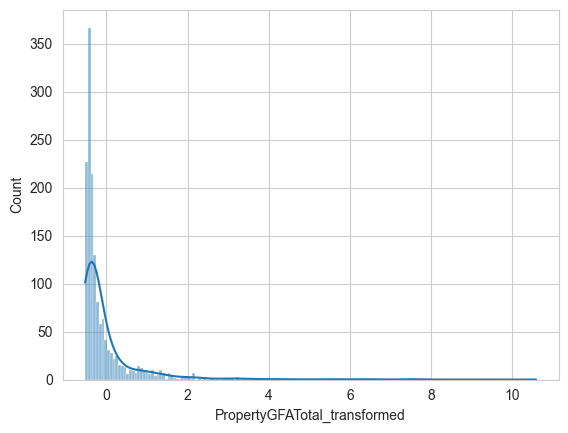

In [156]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data[['PropertyGFATotal']])
data['PropertyGFATotal_transformed'] = scaler.transform(data[['PropertyGFATotal']])

sns.histplot(data['PropertyGFATotal_transformed'], kde=True)